<a href="https://colab.research.google.com/github/Satwikram/Extending-Existing-Tf-model-with-more-classes/blob/main/Extending_Existing_Tf_model_with_more_class.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Author: Satwik Ram K
### Adding Classes to existing Tensorflow model


### Connecting to Kaggle

In [1]:
from google.colab import files

files.upload()


! mkdir ~/.kaggle


! cp kaggle.json ~/.kaggle/

! chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [2]:
! kaggle datasets download -d alessiocorrado99/animals10

 99% 579M/586M [00:09<00:00, 132MB/s]
100% 586M/586M [00:09<00:00, 62.6MB/s]


In [ ]:
! unzip /content/animals10.zip

### Importing Librarries

In [1]:
import numpy as np #Linear Algebra
import matplotlib.pyplot as plt
import cv2
import os
import pickle
%matplotlib inline
import pandas as pd
from tqdm import tqdm_notebook as tqdm
import tensorflow as tf

In [2]:
img_size = (224, 224) #Setting all the images to 150 pixels

### Defining the function to get data

In [3]:
classes = []

In [6]:
def get_data(data_dir):
  data = []
  count = 0
  print(os.path.basename(data_dir))
  folder = os.path.basename(data_dir)
  classes.append(folder)
  index = classes.index(folder)
  print(index)
  print(folder)
  for img in os.listdir(data_dir):
    if count == 499:
      break
    else:
      try:
        image_array = cv2.imread(os.path.join(data_dir, img), cv2.IMREAD_COLOR)
        resized_array = cv2.resize(image_array, img_size)
        data.append([resized_array, index])
        count += 1

      except Exception as e:
        print(e)

  print("Collected",count+1,"no of images")
  return data

In [7]:
data = get_data('/content/raw-img/cane')

cane
0
cane
Collected 500 no of images


In [8]:
classes

['cane']

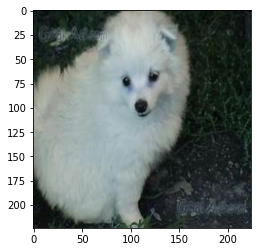

In [10]:
plt.imshow(data[2][0])


In [11]:
data1 = get_data('/content/raw-img/cavallo')

cavallo
1
cavallo
Collected 500 no of images


In [12]:
classes

['cane', 'cavallo']

Text(0.5, 1.0, '1')

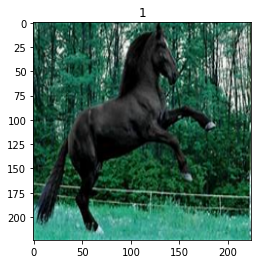

In [14]:
plt.imshow(data1[2][0])
plt.title(data1[2][1])

### Combining the data

In [15]:
dataset = data + data1

In [16]:
print(dataset[400][1])
print(dataset[700][1])

0
1


### Taking X and Y

In [17]:
X = []
y = []

In [18]:
for i in range(len(dataset)):
  X.append(dataset[i][0])
  y.append(dataset[i][1])

In [19]:
print(len(X))
print(len(y))

998
998


### Normalizing the Data

In [20]:
X = np.array(X)
y = np.array(y)

In [23]:
y[997]

1

In [24]:
type(y[0])

numpy.int64

In [25]:
X = X / 255.0

### Splitting the data

In [26]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 388)


In [27]:
X_train[0].shape

(224, 224, 3)

In [28]:
print(len(X_train))
print(len(y_train))

798
798


In [30]:
y_train = tf.keras.utils.to_categorical(y_train, 2)
y_test = tf.keras.utils.to_categorical(y_test, 2)

In [31]:
y_train

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       ...,
       [0., 1.],
       [0., 1.],
       [0., 1.]], dtype=float32)

### Building the model

In [32]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten, Activation

In [53]:
def build_model():
  model = Sequential()

  model.add(Conv2D(filters = 64, kernel_size = (3,3), input_shape = X_train[0].shape, padding = 'same'))
  model.add(Activation('relu'))
  model.add(MaxPooling2D((2,2)))
  model.add(Dropout(0.25))

  model.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'same'))
  model.add(Activation('relu'))
  model.add(MaxPooling2D((2,2)))
  model.add(Dropout(0.5))

  model.add(Conv2D(256, (3,3), padding = 'same'))
  model.add(Activation('relu'))
  model.add(MaxPooling2D((2,2)))
  model.add(Dropout(0.5))

  model.add(Flatten())
  model.add(Dense(512))
  model.add(Activation('relu'))
  model.add(Dropout(0.5))
  model.add(Dense(2))
  model.add(Activation('softmax'))

  return model

In [54]:
model = build_model()

In [55]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 224, 224, 64)      1792      
_________________________________________________________________
activation_10 (Activation)   (None, 224, 224, 64)      0         
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 112, 112, 64)      0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 112, 112, 128)     73856     
_________________________________________________________________
activation_11 (Activation)   (None, 112, 112, 128)     0         
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 56, 56, 128)      

### Creating Checkpoints and Callbacks

In [56]:
from tensorflow.keras.optimizers import SGD, RMSprop
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

In [57]:
checkpoint = ModelCheckpoint("animals.h5",
                             monitor="val_loss",
                             mode="min",
                             save_best_only = True,
                             verbose=1)

In [58]:
earlystop = EarlyStopping(monitor = 'val_loss', 
                          min_delta = 0, 
                          patience = 3,
                          verbose = 1,
                          restore_best_weights = True)

In [59]:
reduce_lr = ReduceLROnPlateau(monitor = 'val_loss',
                              factor = 0.2,
                              patience = 3,
                              verbose = 1,
                              min_delta = 0.0001)

In [60]:
# we put our call backs into a callback list/
callbacks = [earlystop, checkpoint, reduce_lr]

### Compiling the model

In [61]:
# We use a very small learning rate 
model.compile(loss = 'categorical_crossentropy',
              optimizer = RMSprop(lr = 0.001),
              metrics = ['accuracy'])

### Training the model

In [ ]:
model.fit(X_train, y_train, epochs = 10, validation_split = 0.1, callbacks = callbacks)

Epoch 1/10
 9/23 [==========>...................] - ETA: 2:01 - loss: 0.0646 - accuracy: 0.9688

In [ ]:
c